# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import plotly.express as px
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables

In [3]:
# Generic MC15ri Ntuple locations
columns += ['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']
sig_region = uproot.concatenate([f'../../Samples/Generic_MC15ri/mu_channel/MC15ri_1ab_persian_mu_1/AfterBDTcut/*.root:B0'],
                          library="np",
#                           cut='(mode>=5) & (mode<=15)',
                          filter_branch=lambda branch: branch.name in columns)
# fakeD_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/*.root:B0'],
#                           library="np",
#                           cut='mode==0',
#                           filter_branch=lambda branch: branch.name in columns)
# fakeB_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/*.root:B0'],
#                           library="np",
#                           cut='(mode>=2) & (mode<=4)',
#                           filter_branch=lambda branch: branch.name in columns)

# conti_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/continuum/MC15ri_continuum_1ab_e_2/*.root:B0'],
#                           library="np",
#                           #cut=sig_input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

df_sig_region = pd.DataFrame(sig_region)
# df_fakeD = pd.DataFrame(fakeD_mc15ri)
# df_fakeB = pd.DataFrame(fakeB_mc15ri)
# df_conti = pd.DataFrame(conti_mc15ri)

In [4]:
samples=util.get_dataframe_samples_new(df_sig_region, 'mu', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 68563
bkg_TDFl 9174
bkg_fakeTracks 3323
bkg_continuum 2995
bkg_combinatorial 4815
bkg_singleBbkg 3338
bkg_other_TDTl 0
$D\tau\nu$ 2919
$D^\ast\tau\nu$ 1487
$D\ell\nu$ 55378
$D^\ast\ell\nu$ 36564
$D^{\ast\ast}\tau\nu$ 850
$D^{\ast\ast}\ell\nu$ 19663
$D\ell\nu$_gap 3858
bkg_other_signal 0


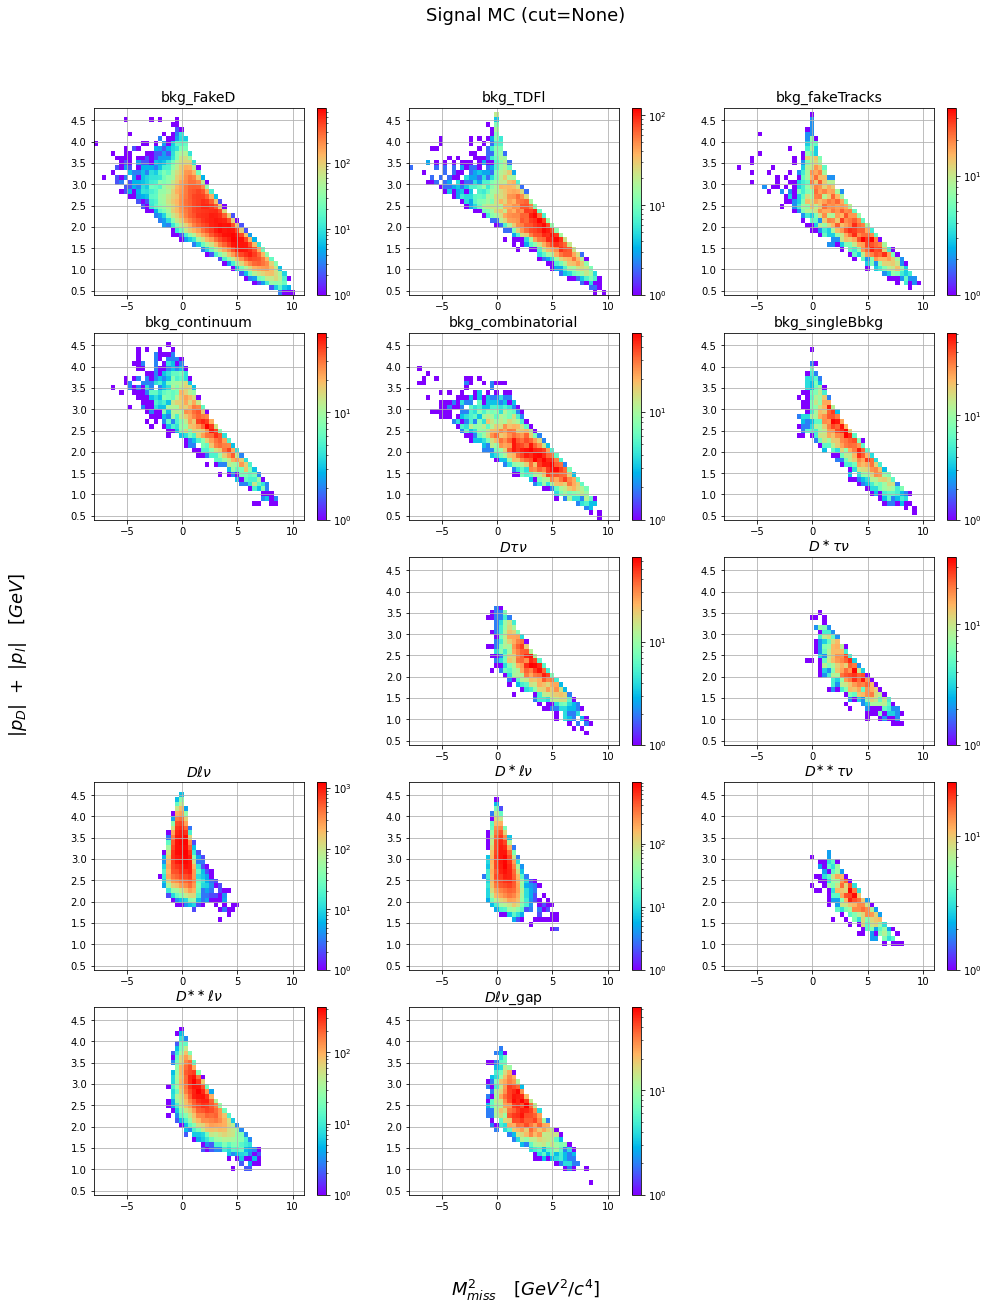

In [13]:
mpl.plot_hist_2d(mask=None)

In [4]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

cut='signal_prob==largest_prob and signal_prob>0.8 and D_daughter_pValue_min>D_daughter_pValue_mean/100'

In [8]:
# Test, apply the MVA cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_fakeD=df_bestSelected.query('B0_mcErrors!=512 and B0_isContinuumEvent!=1 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [9]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''counts = %d \nmean = %5.3f \nstd = %5.3f''' %(counts,mean,std)

def plot_hist_2d(sample, name, variables=['B0_CMS3_weMissM2','p_D_l'], cut=None):
        variable_x, variable_y = variables
        xedges = np.linspace(-7, 11, 30)
        if variables[1]=='p_D_l':
            yedges = np.linspace(0, 5, 20)
        elif variables[1]=='B_CMS_E':
            yedges = np.linspace(1.4, 5.6, 42)
        
        
        fig = plt.figure(figsize=[8,6])
        sample_size = len(sample.query(cut)) if cut else len(sample)

        ax = fig.add_subplot(1,1,1)
        (counts, xedges, yedges) = np.histogram2d(
                        sample.query(cut)[variable_x] if cut else sample[variable_x], 
                        sample.query(cut)[variable_y] if cut else sample[variable_y],
                        bins=[xedges, yedges])
        counts = counts.T

        mask_arr = np.ones_like(counts)


        X, Y = np.meshgrid(xedges, yedges)
        im=ax.pcolormesh(X, Y, counts, cmap='rainbow', norm=colors.LogNorm(), alpha=mask_arr)
        ax.grid()
        ax.set_xlim(xedges.min(),xedges.max())
        ax.set_ylim(yedges.min(),yedges.max())
        ax.set_title(name,fontsize=14)
        fig.colorbar(im,ax=ax)
        ax.set_title(name,fontsize=14)

        fig.supylabel('$|p_D|\ +\ |p_l|\ \ \ [GeV]$', x=0.03,fontsize=18)
        fig.supxlabel('$M_{miss}^2\ \ \ [GeV^2/c^4]$', y=0.02,fontsize=18)

In [10]:
fakeD_sr = df_fakeD.query('1.855<D_M<1.885')
fakeD_Lsb = df_fakeD.query('D_M<1.855')
fakeD_Rsb = df_fakeD.query('D_M>1.885')

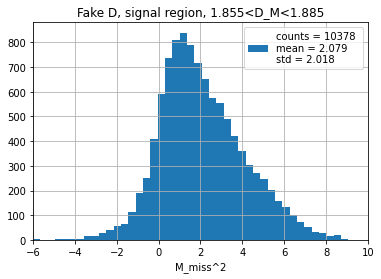

In [11]:
fakeD_sr.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_sr['B0_CMS3_weMissM2']))
plt.title('Fake D, signal region, 1.855<D_M<1.885')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

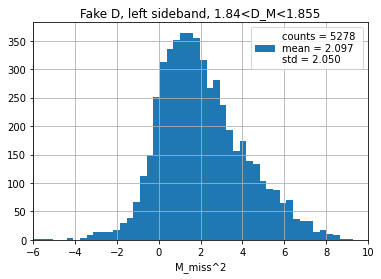

In [12]:
fakeD_Lsb.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_Lsb['B0_CMS3_weMissM2']))
plt.title('Fake D, left sideband, 1.84<D_M<1.855')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

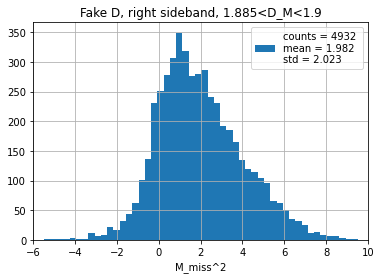

In [13]:
fakeD_Rsb.hist(column='B0_CMS3_weMissM2',bins=50,label=statistics(fakeD_Rsb['B0_CMS3_weMissM2']))
plt.title('Fake D, right sideband, 1.885<D_M<1.9')
plt.xlim(-6,10)
plt.xlabel('M_miss^2')
plt.legend()

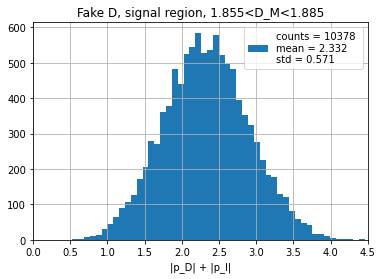

In [14]:
fakeD_sr.hist(column='p_D_l',bins=50,label=statistics(fakeD_sr['p_D_l']))
plt.title('Fake D, signal region, 1.855<D_M<1.885')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

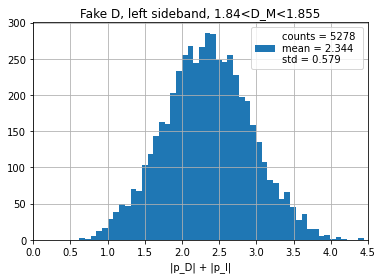

In [15]:
fakeD_Lsb.hist(column='p_D_l',bins=50,label=statistics(fakeD_Lsb['p_D_l']))
plt.title('Fake D, left sideband, 1.84<D_M<1.855')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

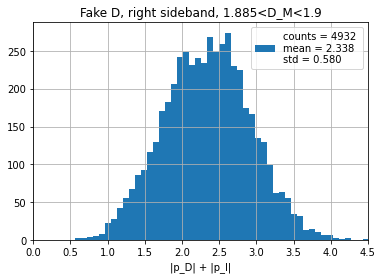

In [16]:
fakeD_Rsb.hist(column='p_D_l',bins=50,label=statistics(fakeD_Rsb['p_D_l']))
plt.title('Fake D, right sideband, 1.885<D_M<1.9')
plt.xlim(0,4.5)
plt.xlabel('|p_D| + |p_l|')
plt.legend()

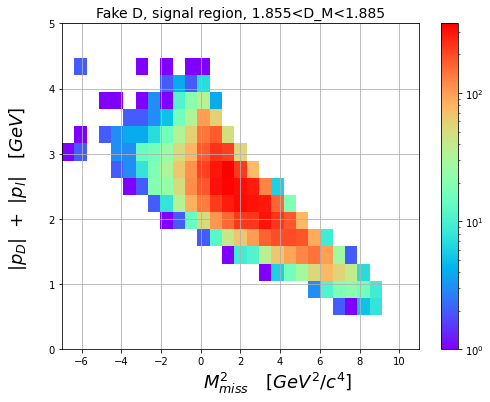

In [17]:
plot_hist_2d(fakeD_sr, name='Fake D, signal region, 1.855<D_M<1.885')

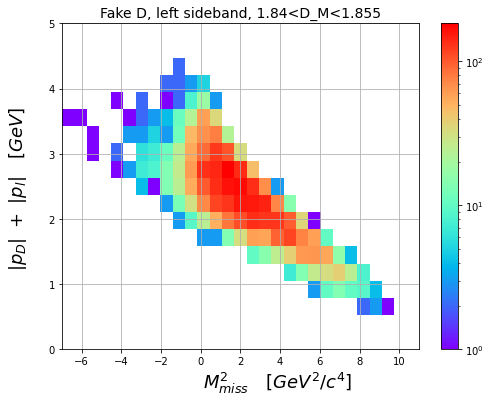

In [18]:
plot_hist_2d(fakeD_Lsb, name='Fake D, left sideband, 1.84<D_M<1.855')

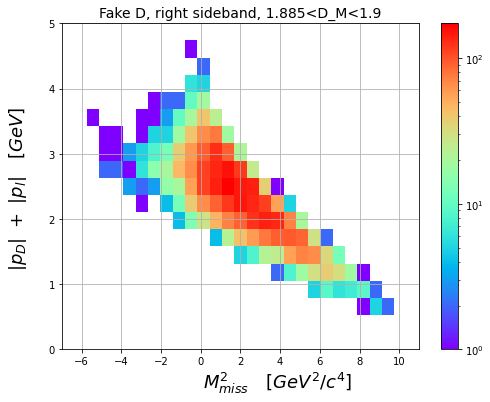

In [19]:
plot_hist_2d(fakeD_Rsb, name='Fake D, right sideband, 1.885<D_M<1.9')

In [7]:
fakeK = df_fakeTrack.query('D_K_mcErrors==512')
fakePi1 = df_fakeTrack.query('D_pi1_mcErrors==512')
fakePi2 = df_fakeTrack.query('D_pi2_mcErrors==512')

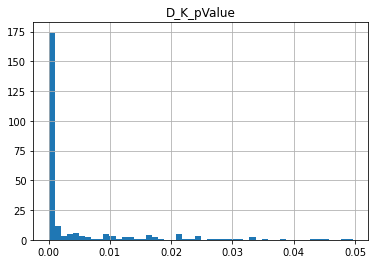

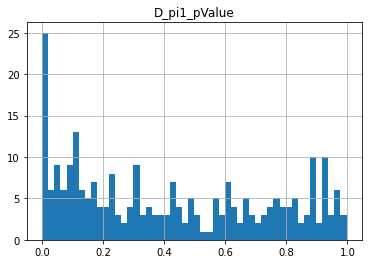

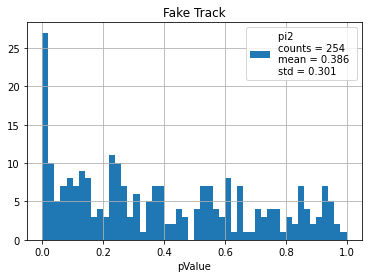

In [14]:
fakeK.hist(column='D_K_pValue',bins=50,label='K \n'+statistics(fakeK['D_K_pValue']))
fakeK.hist(column='D_pi1_pValue',bins=50,label='pi1 \n'+statistics(fakeK['D_pi1_pValue']))
fakeK.hist(column='D_pi2_pValue',bins=50,label='pi2 \n'+statistics(fakeK['D_pi2_pValue']))
plt.title('Fake Track')
#plt.xlim(-6,10)
plt.xlabel('pValue')
plt.legend()

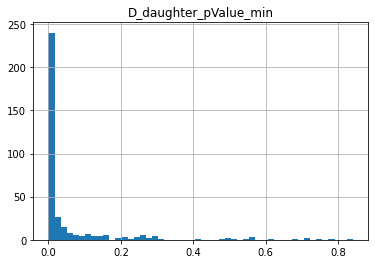

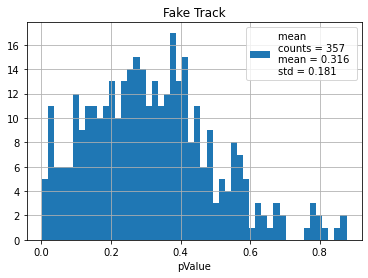

In [8]:
fakeK.hist(column='D_daughter_pValue_min',bins=50,label='min \n'+statistics(fakeK['D_daughter_pValue_min']))
fakeK.hist(column='D_daughter_pValue_mean',bins=50,label='mean \n'+statistics(fakeK['D_daughter_pValue_mean']))
plt.title('Fake Track')
#plt.xlim(-6,10)
plt.xlabel('pValue')
plt.legend()

In [11]:
# apply but skip the MVA cut
df_cut=df_lgb#.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'ell', template=False, new=True)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 2704
$D^\ast\tau\nu$ 2012
$D^{\ast\ast}\tau\nu$_mixed 614
$D^{\ast\ast}\tau\nu$_charged 1092
$D\ell\nu$ 103807
$D^\ast\ell\nu$ 83765
res_$D^{\ast\ast}\ell\nu$_mixed 22242
nonres_$D^{\ast\ast}\ell\nu$_mixed 4002
gap_$D^{\ast\ast}\ell\nu$_mixed 7977
res_$D^{\ast\ast}\ell\nu$_charged 31352
nonres_$D^{\ast\ast}\ell\nu$_charged 5604
bkg_fakeTC 73315
bkg_continuum 0
bkg_fakeD 1488842
bkg_combinatorial 103119
bkg_Odecay 55955
bkg_others 0


In [12]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.


In [13]:
# apply the MVA cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'ell', template=False, new=True)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 1110
$D^\ast\tau\nu$ 618
$D^{\ast\ast}\tau\nu$_mixed 114
$D^{\ast\ast}\tau\nu$_charged 210
$D\ell\nu$ 27944
$D^\ast\ell\nu$ 18792
res_$D^{\ast\ast}\ell\nu$_mixed 3765
nonres_$D^{\ast\ast}\ell\nu$_mixed 438
gap_$D^{\ast\ast}\ell\nu$_mixed 711
res_$D^{\ast\ast}\ell\nu$_charged 5394
nonres_$D^{\ast\ast}\ell\nu$_charged 624
bkg_fakeTC 566
bkg_continuum 0
bkg_fakeD 20588
bkg_combinatorial 2879
bkg_Odecay 2706
bkg_others 0


In [ ]:
df_test8 = samples[r'bkg_fakeTC'].query('D_K_mcErrors==512')
df_test8[['B0_mcErrors','B0_mcPDG','D_mcErrors','D_mcPDG','D_genMotherPDG','e_genMotherPDG',
          'e_mcErrors','e_mcPDG','B0_mcDaughter_0_PDG','B0_mcDaughter_1_PDG',
          'D_K_pValue','D_pi1_pValue','D_pi2_pValue']]

In [19]:
df_test8.D_pi2_pValue.describe()

count    3.570000e+02
mean     4.010878e-01
std      3.027756e-01
min      4.032672e-24
25%      1.329615e-01
50%      3.569602e-01
75%      6.510172e-01
max      9.997345e-01
Name: D_pi2_pValue, dtype: float64

In [34]:
df_test8.index

Int64Index([412, 1016, 1101, 1109, 1263, 1751], dtype='int64')

In [15]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.


In [ ]:
test_p = [0,0.02,0.04,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.97,0.98]
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'], bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum'], variable='signal_prob', test_points=test_p, cut=None)

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3 and e_pSig<100')

In [ ]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1'))/(len(df)+1))

In [ ]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1 and ROEeidBDT<0.5 and ROEmuidBDT<0.5'))/(len(df)+1))

# 2. Plot

In [ ]:
samples[r'$D\ell\nu$'].eval('e_pSig = (e_mcP - e_p)/e_pErr', inplace=True)
samples[r'$D\ell\nu$'].hist('e_pSig',bins=25, by='e_isBremsCorrected')

In [ ]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=[1.6,1,0.1])

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=None)

In [ ]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', variables=['B0_CMS3_weMissM2','B_CMS_E'],mask=None)

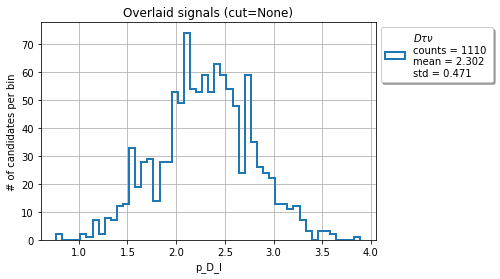

In [17]:
mpl.plot_all_overlaid(variable='p_D_l',cut=None,
                      mask=['bkg_fakeTC','bkg_fakeD','bkg_combinatorial',
                            'bkg_Odecay',r'$D\ell\nu$',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
#plt.xlim(1.84,1.9)

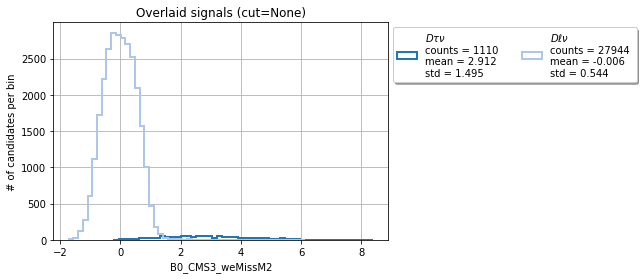

In [19]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeTC','bkg_fakeD','bkg_combinatorial',
                            'bkg_Odecay',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
#plt.xlim(1.84,1.9)

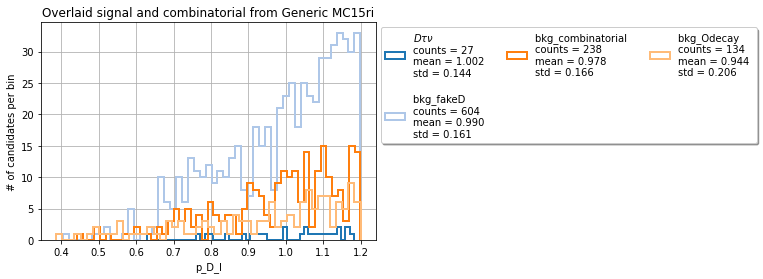

In [19]:
mpl.plot_all_overlaid(variable='p_D_l',cut='B0_CMS3_weMissM2>2.5 and cos_D_l>0.5 and p_D_l<1.2',
                      mask=['bkg_fakeTC',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
# plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal and combinatorial from Generic MC15ri');

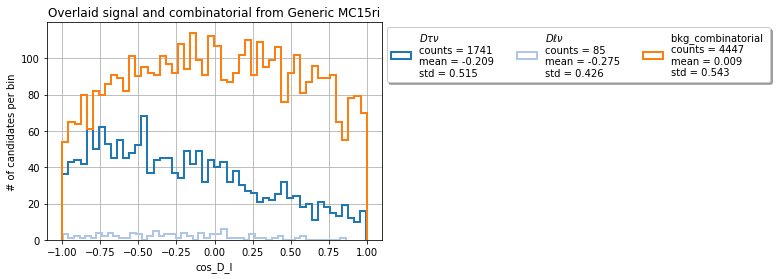

In [11]:
mpl.plot_all_overlaid(variable='cos_D_l',cut='B0_CMS3_weMissM2>2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_fakeTC',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
# plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal and combinatorial from Generic MC15ri');

In [ ]:
mpl.plot_all_overlaid(variable='e_CMS_p',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$|p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$')
plt.title('Overlaid signal MC (different components are scaled)');

In [ ]:
mpl.plot_signals_overlaid(variable='p_D_l',cut='B0_CMS3_weMissM2<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_signals_overlaid(variable='e_CMS_p',cut='B0_CMS3_weMissM2<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_signals_overlaid(variable='B0_CMS3_weMissM2',cut='p_D_l<2.5',
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial','bkg_fakeTC',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

In [ ]:
mpl.plot_cut_efficiency(cut='signal_prob==largest_prob and signal_prob>0.8', variable='B0_CMS3_weQ2lnuSimple')

In [ ]:
mpl.plot_all_separately(variable='B0_CMS3_weQ2lnuSimple',xlim=[-2,13])